In [1]:
import os
import numpy as np
import cv2
from skimage import exposure

from module.load_data import load_dcm, load_nii 

def load_jpg(jpg_path, target_size=(224, 224)):
    # 加载 DICOM 图像
    jpg_image = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)
    jpg_image = jpg_image.astype(np.float32)

    jpg_image_normalized = (jpg_image - np.min(jpg_image)) / (np.max(jpg_image) - np.min(jpg_image))  

    jpg_image = exposure.equalize_adapthist(jpg_image_normalized, clip_limit=0.05)


    return jpg_image

# 遍历病人的姓名，找到对应的文件夹并加载图像
def process_images_for_patients(base_path, target_size=(224, 224)):

    # 获取所有病人文件夹
    all_folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])

    # 按病人分组文件夹，每两个文件夹为一个病人
    patient_folders = []
    for i in range(0, len(all_folders), 2):
        if i + 1 < len(all_folders):
            patient_folders.append([all_folders[i], all_folders[i + 1]])


    # for _, row in labels_df.iterrows():
    #     label = row['N分期']  # 获取病人标签（N分期）
        
    # 加载每个文件夹中的图像
    patient_images = []

    for folder_pair in patient_folders:
        all_images = []
        for folder in folder_pair:
            dcm_file = None
            nii_file = None
            jpg_file = None

            # print(folder)

            # 查找对应的 .dcm 和 .nii 文件
            for file in os.listdir(os.path.join(base_path, folder)):
                if file.endswith('.dcm'):
                    dcm_file = os.path.join(base_path, folder, file)
                elif file.endswith('.nii.gz'):
                    nii_file = os.path.join(base_path, folder, file)
                elif file.endswith('.jpg'):
                    jpg_file = os.path.join(base_path, folder, file)
                           
            # print(f"dcm_file: {dcm_file}, nii_file: {nii_file}")

            if dcm_file and nii_file:
                # 读取并处理 .dcm 和 .nii 图像
                dcm_image = load_dcm(dcm_file)
                nii_mask , top_left, bottom_right = load_nii(nii_file)

                dcm_image = dcm_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

                # 将两个图像相乘
                focused_image = dcm_image * nii_mask

                focused_image = cv2.resize(focused_image, target_size)
                all_images.append(focused_image)
            
            elif jpg_file and nii_file:
                # print(f"folder {folder} jpg")
                jpg_image = load_jpg(jpg_file, target_size)
                nii_mask , top_left, bottom_right = load_nii(nii_file)

                jpg_image = jpg_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

                focused_jpg_image = jpg_image * nii_mask

                focused_jpg_image = cv2.resize(focused_jpg_image, target_size)
                
                all_images.append(focused_jpg_image)

            elif dcm_file:
                # print(f"folder {folder} no nii")
                dcm_image = load_dcm(dcm_file)
                dcm_image = cv2.resize(dcm_image, target_size)
                all_images.append(dcm_image)

                        
        if len(all_images) == 2:  # 确保每个病人有 2 张图像

            # print(all_images[0].shape)
            # 将两个图像堆叠在一起
            patient_input = np.stack(all_images, axis=0)  # 形状为 (2, 512, 512)
            # 追加至列表中
            patient_images.append(patient_input)

        else:
            print(f"Skipping patient {folder_pair} due to missing images")

    return patient_images

base_path = './data/chaoyang_qianzhan_190'  # 图像数据的根目录
target_size = (224, 224)  # 目标图像尺寸
patient_images = process_images_for_patients(base_path, target_size)

In [7]:
from module.load_data import cache_dataset

test_cache_path = 'cache/test.npy'
cache_dataset(patient_images, test_cache_path, format='npy')

In [19]:
import pandas as pd
from pathlib import Path
import numpy as np

from module.load_data import load_cached_dataset,create_imgWithLabels

test_cache_path = 'cache/test.npy'
patient_images = load_cached_dataset(test_cache_path, format='npy')
excel_path = './data/beiyou_excel/chaoyang_qianzhan_190.xlsx'  # 包含病人姓名和标签的Excel文件路径
labels_df = pd.read_excel(excel_path)

images_with_labels = create_imgWithLabels(patient_images , labels_df)

In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader

from module.dataset import ImageDataset

# 测试数据预处理，与验证集一致
test_transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5], [0.5, 0.5]),  # 标准化
])

# 创建测试数据集
test_dataset = ImageDataset(images_with_labels, transform=test_transform)

# 创建测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

使用设备: cuda


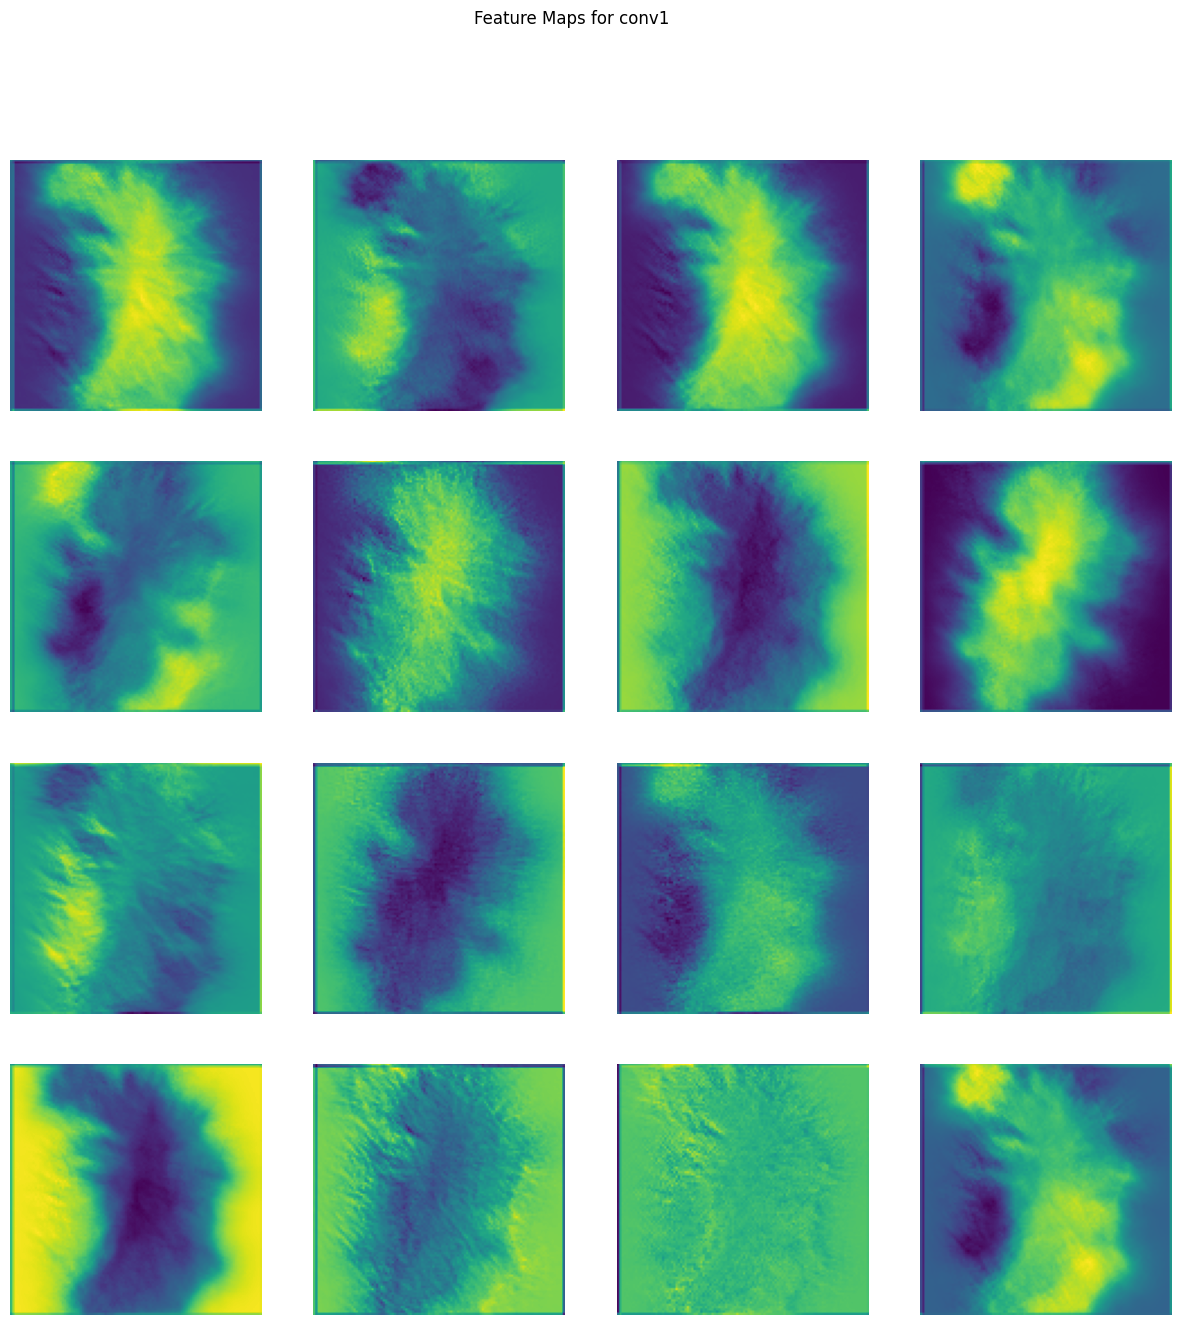

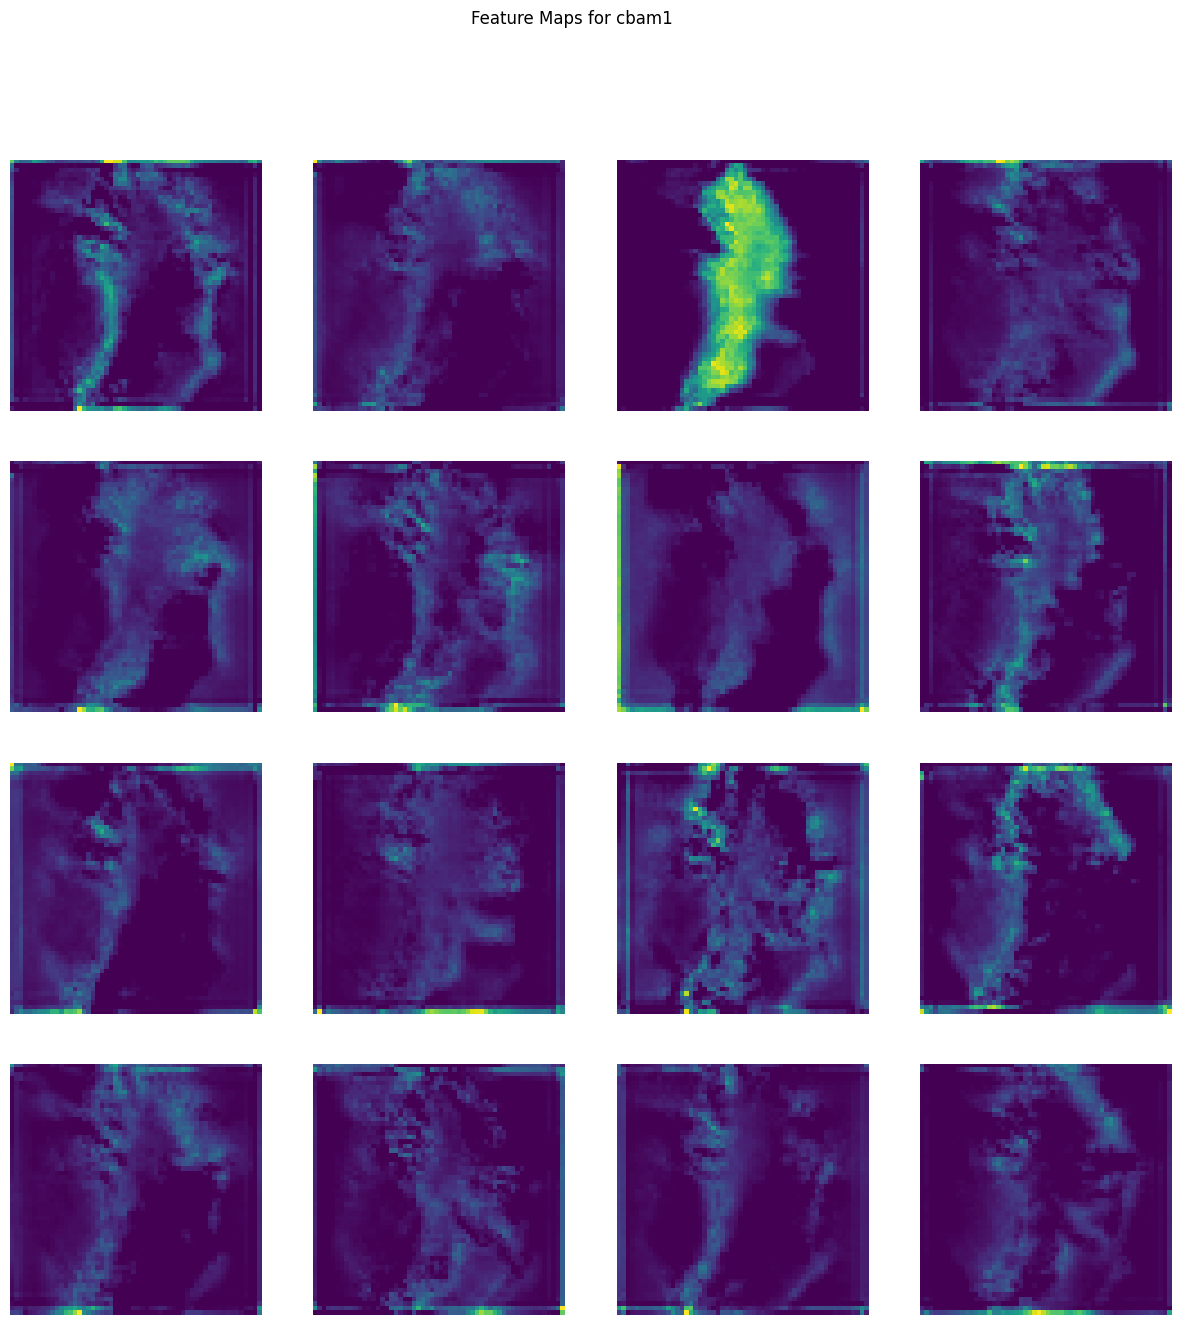

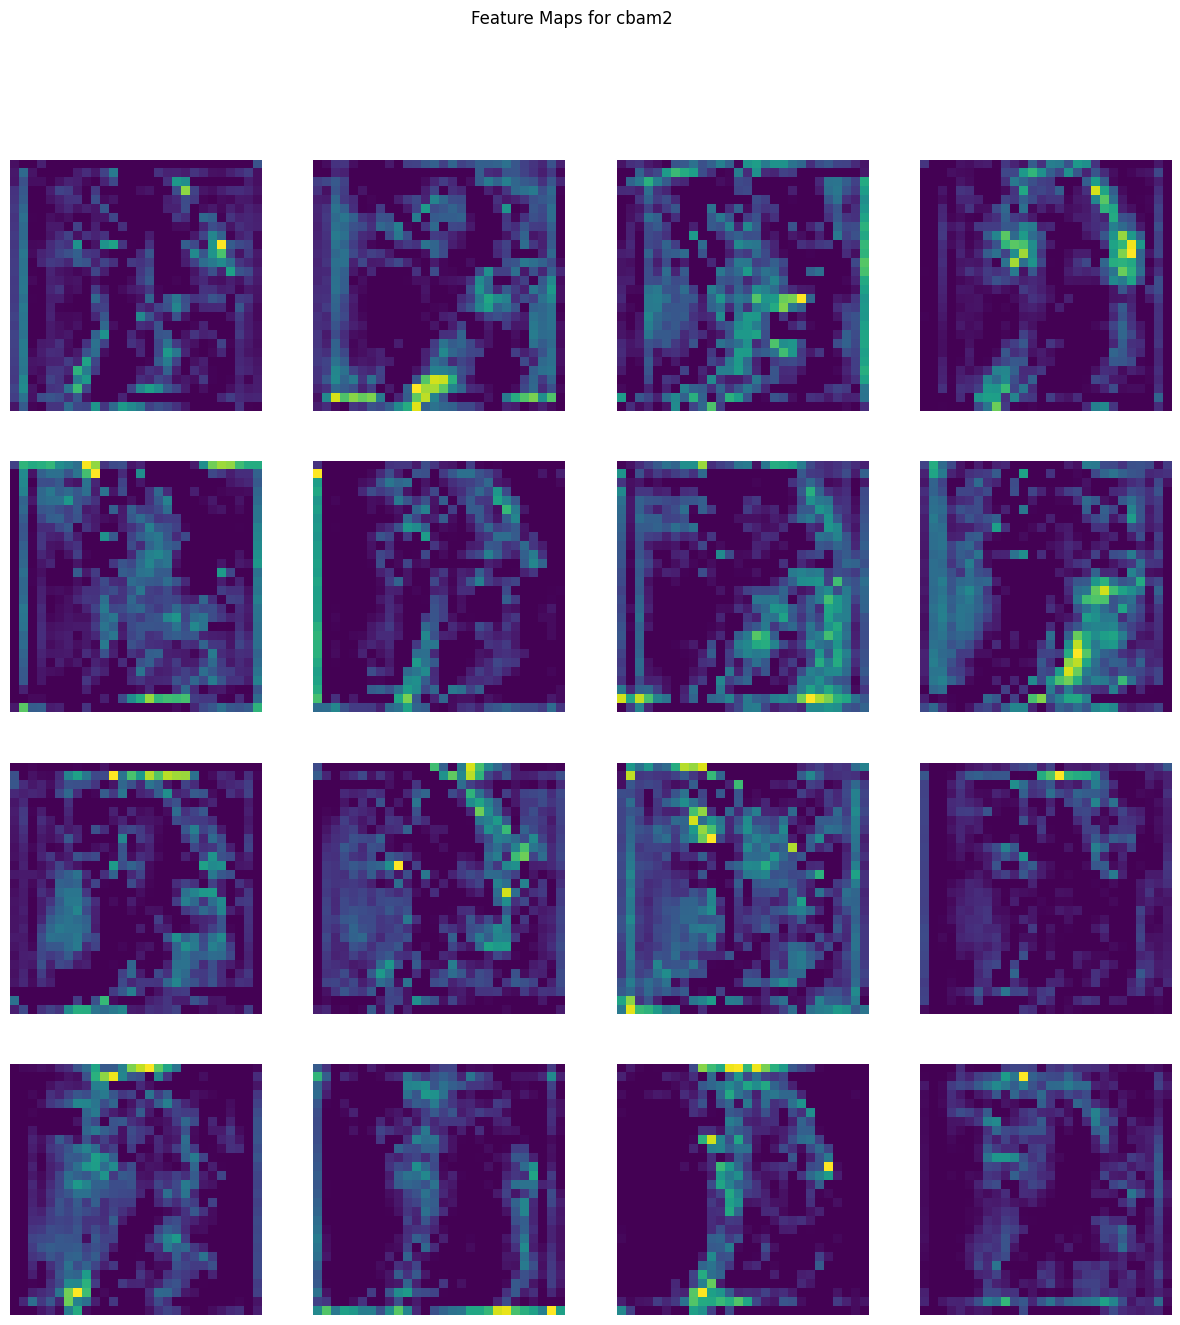

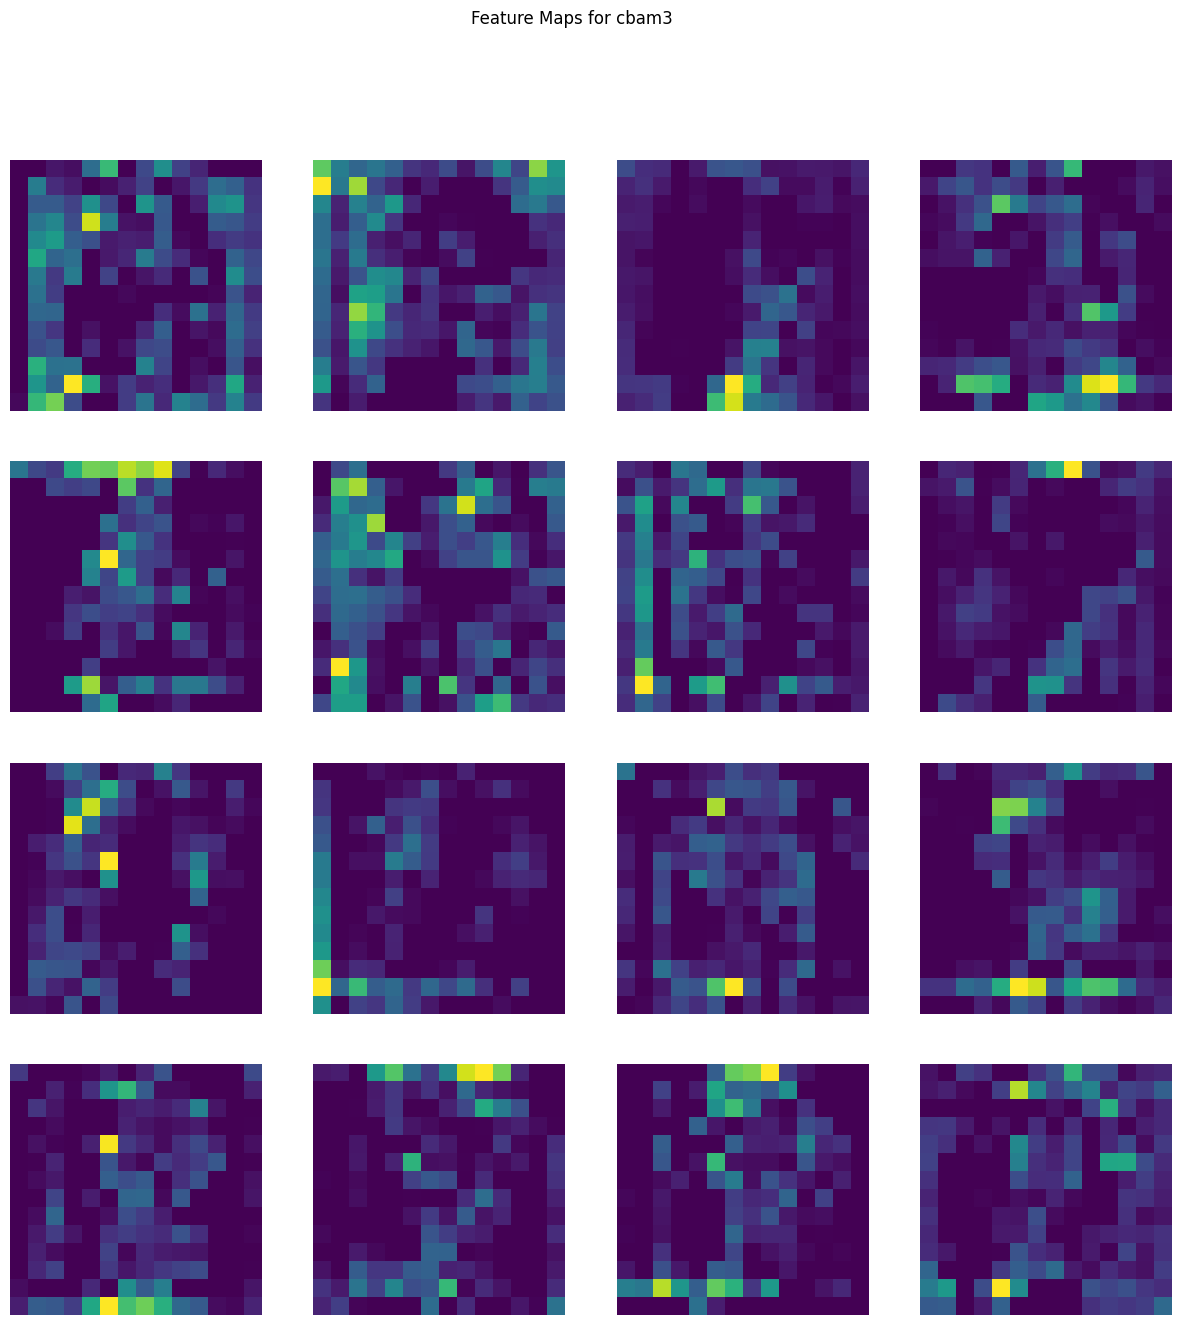

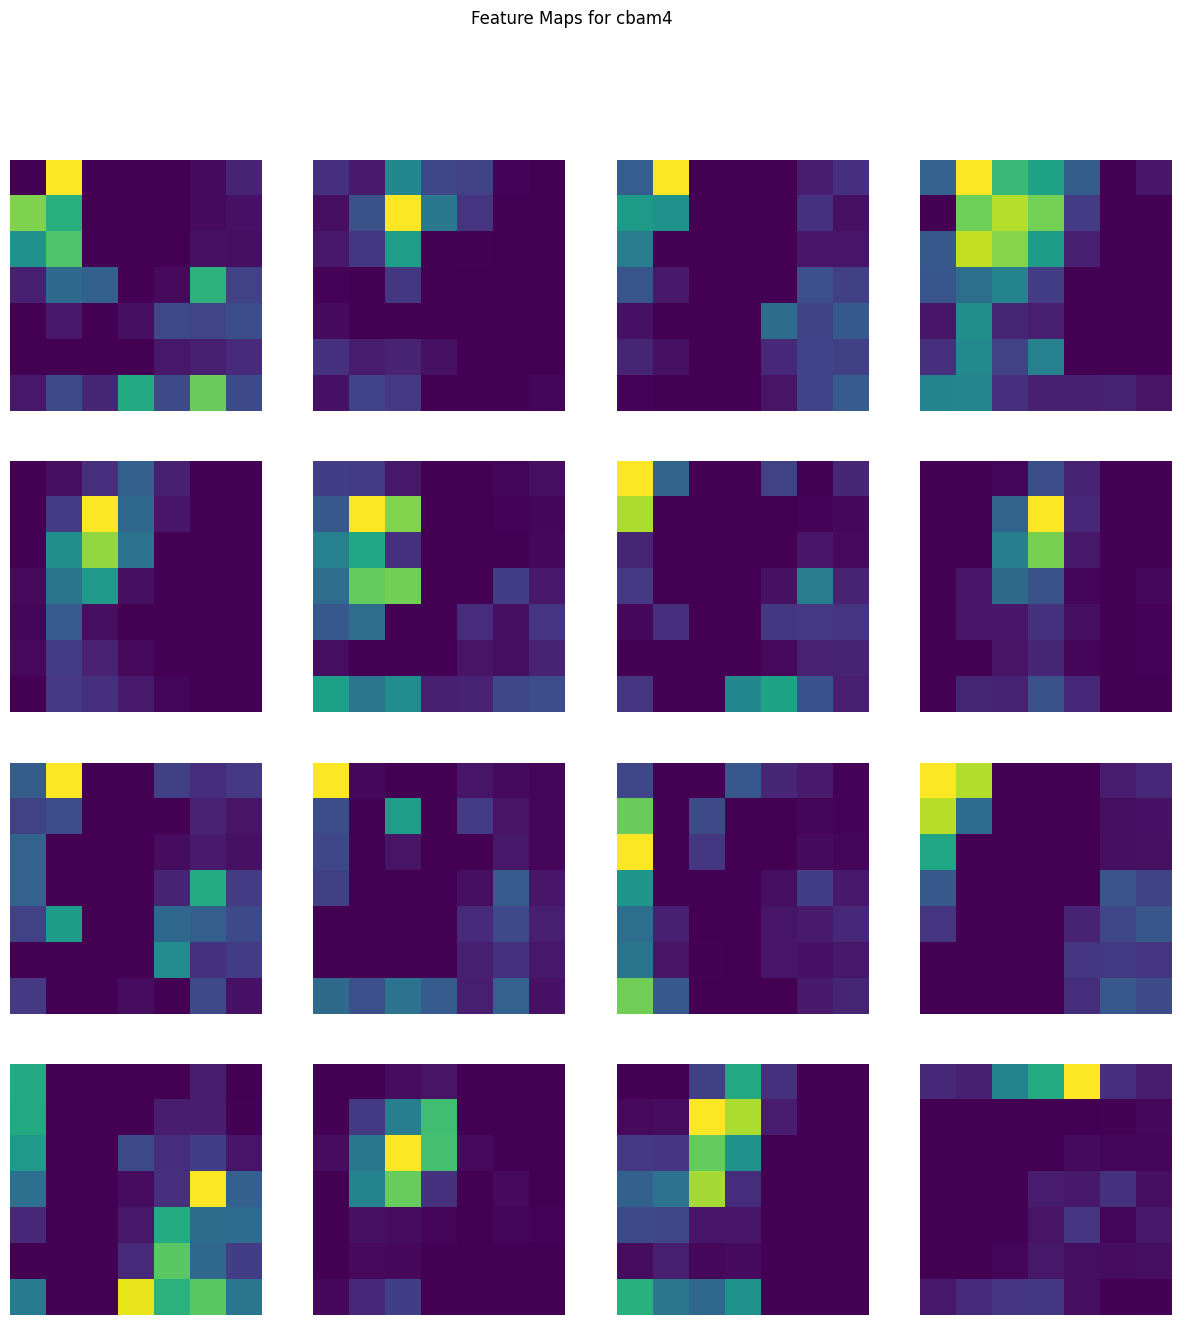

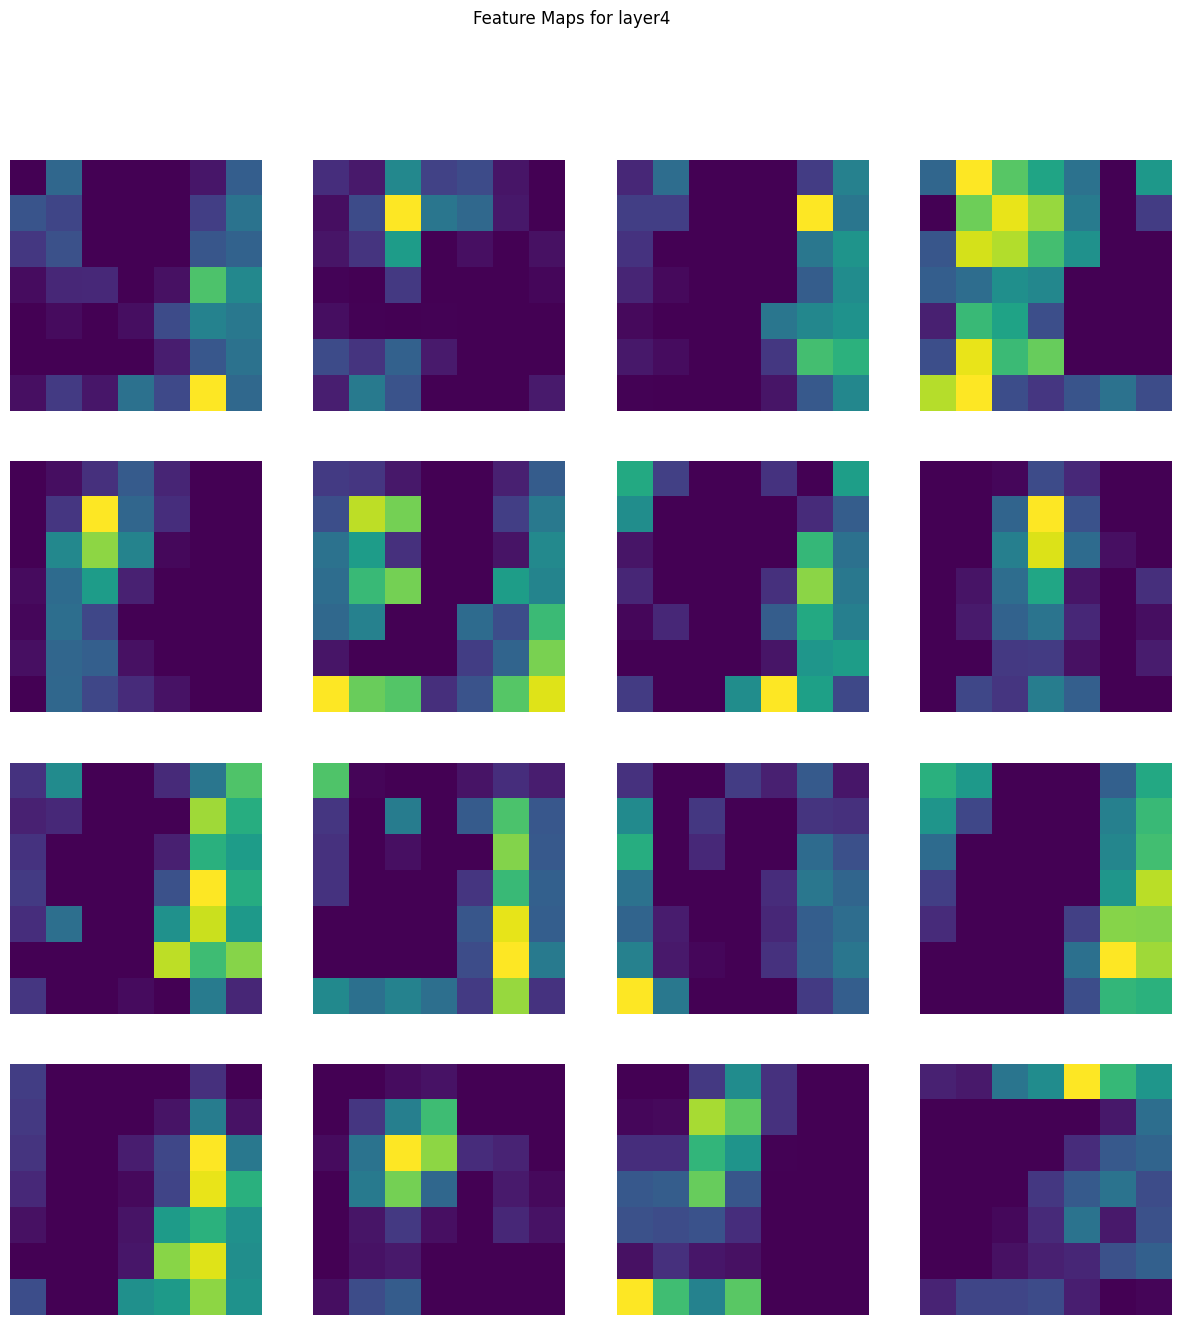

In [21]:
import torch
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

import module.model
import importlib
importlib.reload(module.model)

from module.model import Resnet18_cbam

import torch
import matplotlib.pyplot as plt
import numpy as np

class FeatureExtractor():
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.features = {layer: None for layer in target_layers}
        self.hooks = []
        self._register_hooks()
        
    def _get_activation(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach()
        return hook
    
    def _register_hooks(self):
        for name in self.target_layers:
            layer = self._get_layer(name)
            hook = layer.register_forward_hook(self._get_activation(name))
            self.hooks.append(hook)
    
    def _get_layer(self, name):
        if name == 'conv1':
            return self.model.base_model.conv1
        elif name.startswith('cbam'):
            return getattr(self.model, name)
        elif name.startswith('layer'):
            return getattr(self.model.base_model, name)
        else:
            raise ValueError(f"Unknown layer name: {name}")
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
    
    def visualize_features(self, input_tensor, save_path=None):
        self.model.eval()
        with torch.no_grad():
            _ = self.model(input_tensor)
        
        for layer_name, feature in self.features.items():
            feature = feature.squeeze(0).cpu()
            
            # 计算要显示的特征图数量（最多显示16个）
            n_features = min(16, feature.shape[0])
            n_rows = int(np.sqrt(n_features))
            n_cols = int(np.ceil(n_features / n_rows))
            
            plt.figure(figsize=(15, 15))
            plt.suptitle(f'Feature Maps for {layer_name}')
            
            for idx in range(n_features):
                plt.subplot(n_rows, n_cols, idx + 1)
                plt.imshow(feature[idx], cmap='viridis')
                plt.axis('off')
            
            if save_path:
                plt.savefig(f'{save_path}{layer_name}.png')
            plt.show()
            plt.close()


def visualize_model_features(model, image, save_path=None):
    # 定义要观察的层
    target_layers = [
        'conv1',      # 初始卷积层
        'cbam1',      # 第一个CBAM
        'cbam2',      # 第二个CBAM
        'cbam3',      # 第三个CBAM
        'cbam4',      # 第四个CBAM
        'layer4'      # 最后的残差块
    ]
    
    # 创建特征提取器
    extractor = FeatureExtractor(model, target_layers)
    
    # 可视化特征
    extractor.visualize_features(image, save_path)
    
    # 移除钩子
    extractor.remove_hooks()

# 在测试代码中使用
def test_with_visualization(model, test_loader, device):
    model.eval()
    
    # 获取一个批次的数据
    images, labels = next(iter(test_loader))
    
    # 选择第一张图片进行可视化
    sample_image = images[0:1].to(device)
    
    # 可视化特征
    visualize_model_features(
        model, 
        sample_image,
        save_path='./image/'  
    )

model = Resnet18_cbam(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"使用设备: {device}")
model_path = './model_save/best_auc_1_25.pth'
model.load_state_dict(torch.load(model_path,weights_only=True))
test_with_visualization(model, test_loader, device)


# layers = []
# with open('./test.txt','w') as f:
#     for layer in model.modules():
#         f.write(str(layer))
#         layers.append(layer)

# print(layers[90])

In [9]:
import module.model
import importlib
importlib.reload(module.model)

from module.model import Resnet18_cbam

import torch
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

def model_test(model, model_path, device = None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"使用设备: {device}")

    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()  # 设置模型为评估模式

    # 初始化变量
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():  # 禁用梯度计算
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 数据移动到设备

            outputs = model(inputs)  # 模型推理
            probs = F.softmax(outputs, dim=1)  # 计算每个类别的概率
            _, predicted = torch.max(outputs, 1)  # 获取预测结果

            # predicted = (torch.sigmoid(outputs) > 0.5).float()
            # correct += (predicted.view(-1) == labels).sum().item()  

            # 统计正确数和总数
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # 收集所有标签和概率
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # 计算准确率
    accuracy = correct / total
    print(f"测试集准确率: {accuracy:.4f}")

    # 计算 AUC
    all_labels = np.concatenate(all_labels)  # 合并所有批次标签
    all_probs = np.concatenate(all_probs)    # 合并所有批次概率

    # 使用正类的概率（假设正类为索引1）
    positive_probs = all_probs[:, 1]

    # 计算每个类别的 AUC
    try:
        auc = roc_auc_score(all_labels, positive_probs)
        print(f"测试集 AUC 值: {auc:.4f}")
    except ValueError as e:
        print(f"AUC 计算失败: {e}")
        

model = Resnet18_cbam(num_classes=2)
model_path = './model_save/best_auc_1_25.pth'
model_test(model,model_path)

使用设备: cuda
测试集准确率: 0.5000
测试集 AUC 值: 0.5103
